In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from skimage.util import random_noise 
import cv2
import matplotlib.pyplot as plt


In [190]:
pip install torchattacks


     |████████████████████████████████| 105 kB 10.6 MB/s 


In [191]:
import torchattacks
from torchattacks import PGD, FGSM, PGDL2

##Define Network

In [169]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1',n_classes=5):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)
            final_K = torch.randn(self.nf, self.n_classes,1)
            final_b = torch.randn(self.n_classes, 1, 1)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)
            final_K = torch.ones(self.nf, self.n_classes, 1)
            final_b = torch.zeros(self.n_classes, 1, 1)
        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)
        self.final_K = nn.Parameter(final_K, True)
        self.final_b = nn.Parameter(final_b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end-1):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput, self.K, self.b

H-DNN

In [170]:
class Net_HDNN(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_HDNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        if net_type == 'H1_J1':
            self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        elif net_type == 'H1_J2':
            self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J2')
        else:
            raise ValueError("%s model is not yet implemented for MNIST" % net_type)
        self.fc_end = nn.Linear(nf*28*28, 10)
        self.nf = nf

    def forward(self, x):
        x = self.conv1(x)
        x = self.hamiltonian(x)[0]
        x = x.reshape(-1, self.nf*28*28)
        output = self.fc_end(x)
        # output = F.log_softmax(x, dim=1)
        return output

Energy-based

In [171]:
def logcos(x):
    return x + torch.log(1+torch.exp(-2.0*x)) - torch.log(torch.tensor(2.0))
    # return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x))) - torch.log(torch.tensor(2.0))

In [172]:
def compute_H(y,K,b):
    dim = len(y.shape)
    y = y.transpose(1, dim-1)
    n_layers = K.shape[-1]
    H = torch.sum(logcos(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1])),dim-1)
    return H

In [173]:
def compute_all_H(y,K,b):
  H_ALL = []
  dim = len(y.shape)
  y = y.transpose(1, dim-1)
  n_layers = K.shape[-1]
  for layer in range(n_layers):
    H_ALL.append(torch.sum(torch.log(torch.cosh(F.linear(
                y.squeeze(2), K[:, :, layer-1].transpose(0, 1), b[:, 0, layer-1]))),dim-1))
  
  return H_ALL

In [174]:
class Net_Energy(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end = nn.Linear(28*28,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x,K,b = self.hamiltonian(x)
        self.H = compute_H(x,K,b)
        self.H_ALL = compute_all_H(x,K,b)
        x = self.H.reshape(-1,28*28)
        output = self.fc_end(x)
        # output = F.log_softmax(x, dim=1)
        return output

## Load Data

In [175]:
use_cuda = torch.cuda.is_available()  # not no_cuda and
batch_size = 100 #100
test_batch_size = 1000
lr = 0.02
gamma = 0.8 #0.8
epochs = 10
seed = np.random.randint(0, 1000)
torch.manual_seed(seed)
np.random.seed(seed)

out = 1
n_classes = 10

In [176]:
# Define the net model
n_layers = 4
net_type = 'H1_J1'

h = 0.4
wd = 4e-3
alpha = 8e-3


device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 20, 'pin_memory': True} if use_cuda else {}


In [199]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data',download=True, train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

## Test with Noises

In [178]:
def test_gaussian(model, device, test_loader, out, var=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='gaussian', mean=0, var=var, clip=True)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Variance:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            var, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [179]:
def test_salt_pepper(model, device, test_loader, out, amount=0.05, count=0):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data*0.3081 + 0.1307
            im_data = torch.tensor(random_noise(data, mode='s&p', amount=amount)).float()
            im_data = (im_data-0.1307) / 0.3081
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Amount:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            amount, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [180]:
def test_gaussian_blur(model, device, out, kernel_size=3, sigma=(1,1), count=0):
    model.eval()
    test_loss = 0
    correct = 0
    H = []
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                            transforms.GaussianBlur(kernel_size,sigma=sigma)
                        ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            im_data = data
            output = model(im_data)
            if count != 2:
              H = model.getH()
            else:
              H = np.zeros(10)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Kernel_size:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            kernel_size, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [181]:
models = [torch.load('Energy_Net.pkl'),torch.load('Ham_Net.pkl'),torch.load('Net_Energy_reg_1e-5.pkl')]
vars = np.linspace(0,1.5,16)
acc_gaussian_all = []
exp_gaussian_all = []
eng_gaussian_all = []
count = 0
for model in models:
  print(model)
  count += 1
  acc_gaussian=[]
  exp_gaussian=[]
  eng_gaussian=[]
  for var in vars:
    test_acc, examples, energy = test_gaussian(model, device, test_loader, out, var, count)
    acc_gaussian.append(test_acc)
    exp_gaussian.append(examples)
    eng_gaussian.append(energy)
  acc_gaussian_all.append(acc_gaussian)
  exp_gaussian_all.append(exp_gaussian)
  eng_gaussian_all.append(eng_gaussian)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=784, out_features=10, bias=True)
)
Variance:0.000 Average loss: 0.2481, Accuracy:  9286/10000 (92.86%)
Variance:0.100 Average loss: 8.3067, Accuracy:  2149/10000 (21.49%)
Variance:0.200 Average loss: 14.3909, Accuracy:  1236/10000 (12.36%)
Variance:0.300 Average loss: 18.3338, Accuracy:  1028/10000 (10.28%)
Variance:0.400 Average loss: 21.1025, Accuracy:   950/10000 (9.50%)
Variance:0.500 Average loss: 23.2395, Accuracy:   913/10000 (9.13%)
Variance:0.600 Average loss: 24.7922, Accuracy:   911/10000 (9.11%)
Variance:0.700 Average loss: 26.0931, Accuracy:   898/10000 (8.98%)
Variance:0.800 Average loss: 27.1192, Accuracy:   897/10000 (8.97%)
Variance:0.900 Average loss: 27.9349, Accuracy:   896/10000 (8.96%)
Variance:1.000 Average loss: 28.7768, Accuracy:   893/10000 (8.93%)
Variance:1.100 Average loss: 29.3903, Accuracy:   894/

In [182]:
amounts = np.linspace(0,0.9,10)
acc_salt_pepper_all = []
exp_salt_pepper_all = []
eng_salt_pepper_all = []
count = 0
for model in models:
  print(model)
  count+=1
  acc_salt_pepper = []
  exp_salt_pepper = []
  eng_salt_pepper = []
  for amount in amounts:
    test_acc, examples, energy = test_salt_pepper(model, device, test_loader, out, amount, count)
    acc_salt_pepper.append(test_acc)
    exp_salt_pepper.append(examples)
    eng_salt_pepper.append(energy)
  acc_salt_pepper_all.append(acc_salt_pepper)
  exp_salt_pepper_all.append(exp_salt_pepper)
  eng_salt_pepper_all.append(eng_salt_pepper)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=784, out_features=10, bias=True)
)
Amount:0.000 Average loss: 0.2481, Accuracy:  9286/10000 (92.86%)
Amount:0.100 Average loss: 5.2790, Accuracy:  3064/10000 (30.64%)
Amount:0.200 Average loss: 12.2738, Accuracy:  1771/10000 (17.71%)
Amount:0.300 Average loss: 18.4000, Accuracy:  1264/10000 (12.64%)
Amount:0.400 Average loss: 23.8509, Accuracy:  1007/10000 (10.07%)
Amount:0.500 Average loss: 28.3806, Accuracy:   920/10000 (9.20%)
Amount:0.600 Average loss: 32.1676, Accuracy:   894/10000 (8.94%)
Amount:0.700 Average loss: 35.2005, Accuracy:   891/10000 (8.91%)
Amount:0.800 Average loss: 37.7573, Accuracy:   892/10000 (8.92%)
Amount:0.900 Average loss: 39.7967, Accuracy:   892/10000 (8.92%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): L

In [183]:
sigmas = []
sigma_range = np.linspace(1,10,10)
kernel_sizes = np.linspace(1,19,10)
acc_gaussian_blur_all = []
exp_gaussian_blur_all = []
eng_gaussian_blur_all = []
count = 0
for model in models:
  print(model)
  count+=1
  acc_gaussian_blur = []
  exp_gaussian_blur = []
  eng_gaussian_blur = []
  for kernel_size in kernel_sizes:
    test_acc, examples, energy = test_gaussian_blur(model, device, out, kernel_size=kernel_size, sigma=3, count=count)
    acc_gaussian_blur.append(test_acc)
    exp_gaussian_blur.append(examples)
    eng_gaussian_blur.append(energy)
  acc_gaussian_blur_all.append(acc_gaussian_blur)
  exp_gaussian_blur_all.append(exp_gaussian_blur)
  eng_gaussian_blur_all.append(eng_gaussian_blur)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=784, out_features=10, bias=True)
)
Kernel_size:1.000 Average loss: 0.2481, Accuracy:  9286/10000 (92.86%)
Kernel_size:3.000 Average loss: 0.3938, Accuracy:  8736/10000 (87.36%)
Kernel_size:5.000 Average loss: 0.7045, Accuracy:  7442/10000 (74.42%)
Kernel_size:7.000 Average loss: 1.1360, Accuracy:  5393/10000 (53.93%)
Kernel_size:9.000 Average loss: 1.5539, Accuracy:  4009/10000 (40.09%)
Kernel_size:11.000 Average loss: 1.8858, Accuracy:  3260/10000 (32.60%)
Kernel_size:13.000 Average loss: 2.1005, Accuracy:  2854/10000 (28.54%)
Kernel_size:15.000 Average loss: 2.2129, Accuracy:  2693/10000 (26.93%)
Kernel_size:17.000 Average loss: 2.2621, Accuracy:  2638/10000 (26.38%)
Kernel_size:19.000 Average loss: 2.2807, Accuracy:  2614/10000 (26.14%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (h

In [270]:
def plot_energy(examples, energy, parameters, Title, y_label, is_regular):
  n_data = 0
  if is_regular:
    n_data = 2
  fig = plt.figure(figsize=(15,15))
  cnt = 0
  # plt.subplots_adjust(wspace = -0.01, hspace = -0.01)#调整子图间距
  for i in range(6):
      for j in range(2):
        cnt += 1
        ax = fig.add_subplot(6, 4, 2*cnt-1)
        # ax.axis('off')
        # plt.subplot(5,10,2*cnt-1)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          ax.set_ylabel(y_label+": {:.2f}".format(parameters[i]),fontsize=20)
        ex = examples[n_data][i][j]
        ax.imshow(ex.squeeze(0), cmap="gray")
        if i<1:
          ax.set_title('Input', fontsize=20)

        # plt.subplot(5,10,2*cnt)
        ax = fig.add_subplot(6,4,2*cnt)
        # plt.xticks([], [])
        # plt.yticks([], [])
        ax.axis('off')
        H = energy[n_data][i][j]
        ax.imshow(H.data.numpy().T, cmap="gray")
        if i<1:
          ax.set_title('Energy', fontsize=20)
  plt.tight_layout()
  # plt.subplots_adjust( 
  #           wspace=0.1, 
  #           hspace=-0.7)
  plt.suptitle(Title,fontsize = 30,y=1.05)
  plt.show()

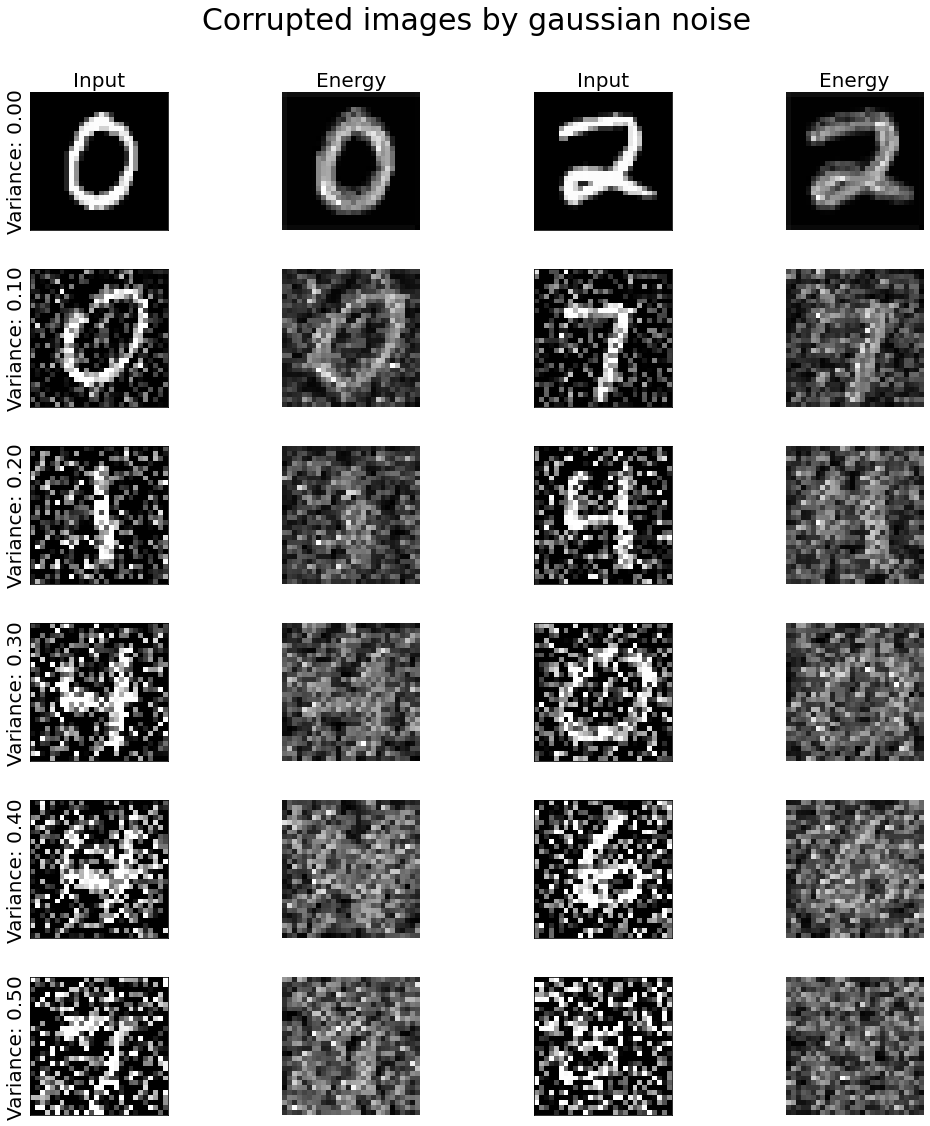

In [271]:
plot_energy(exp_gaussian_all, eng_gaussian_all, vars, Title="Corrupted images by gaussian noise", y_label="Variance", is_regular=0)

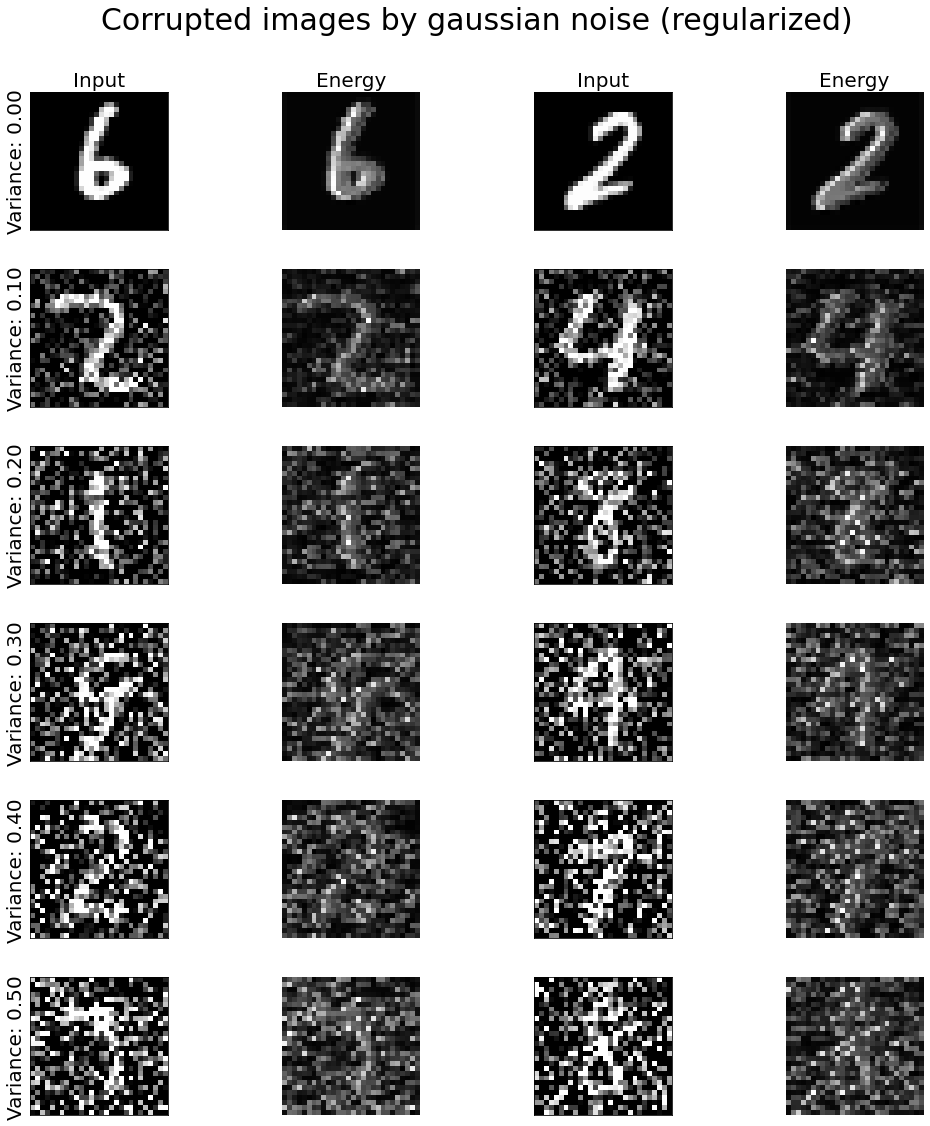

In [272]:
plot_energy(exp_gaussian_all, eng_gaussian_all, vars, Title="Corrupted images by gaussian noise (regularized)", y_label="Variance", is_regular=1)

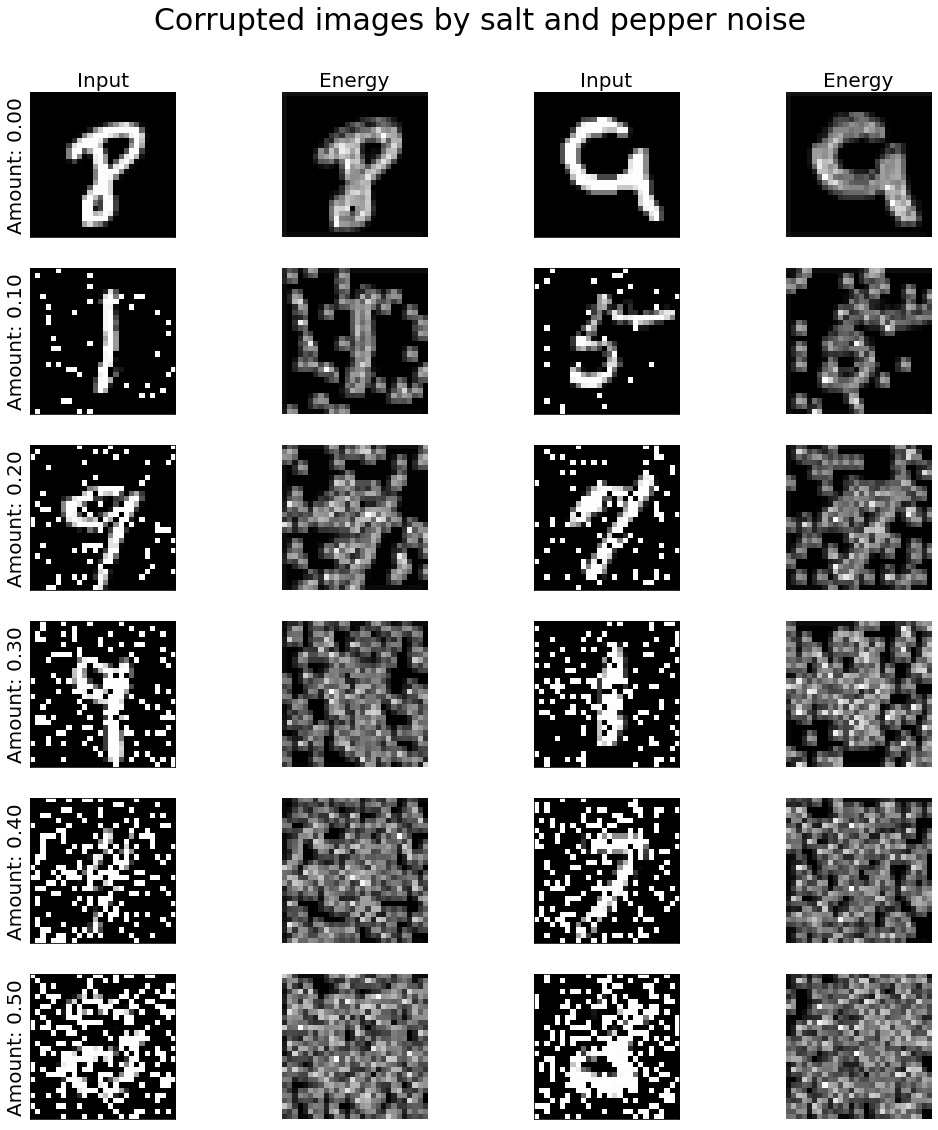

In [273]:
plot_energy(exp_salt_pepper_all, eng_salt_pepper_all, amounts, Title="Corrupted images by salt and pepper noise", y_label="Amount", is_regular=0)

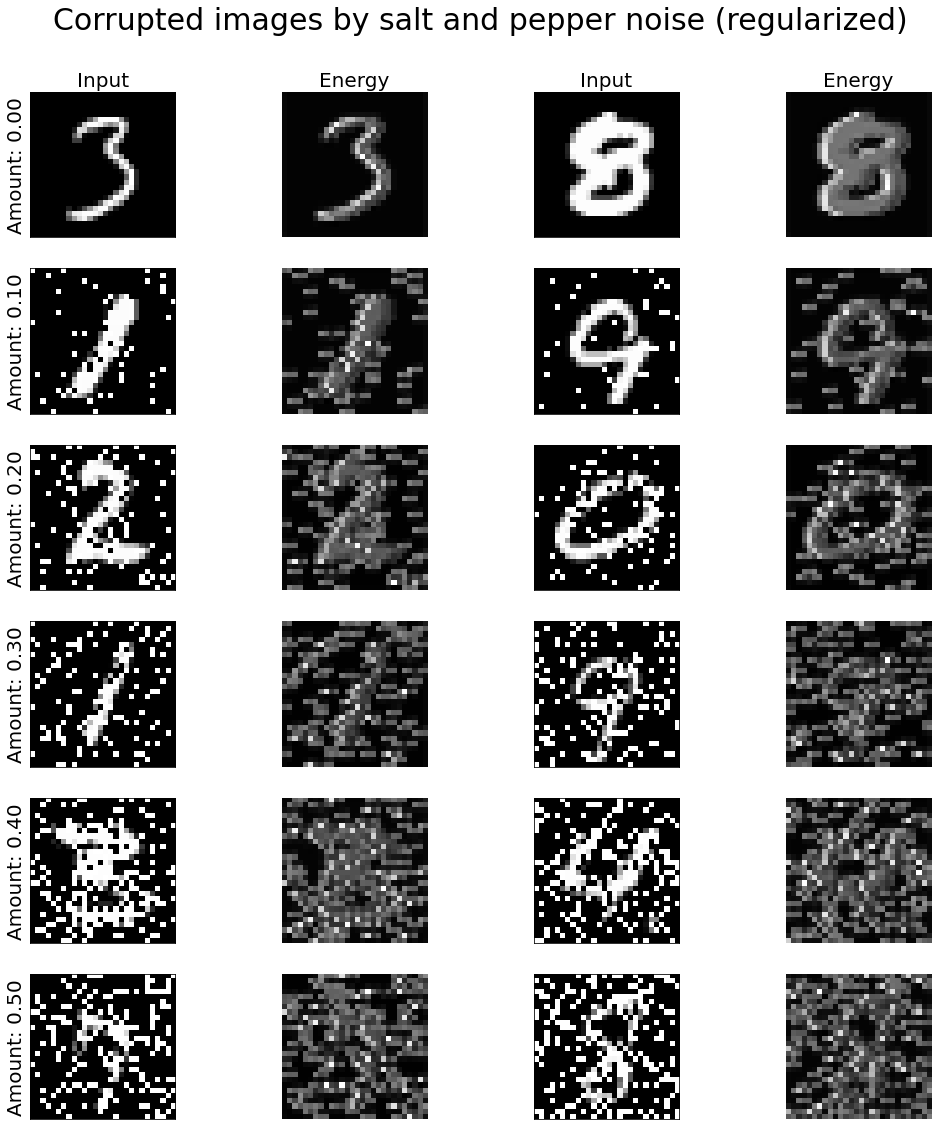

In [274]:
plot_energy(exp_salt_pepper_all, eng_salt_pepper_all, amounts, Title="Corrupted images by salt and pepper noise (regularized)", y_label="Amount", is_regular=1)

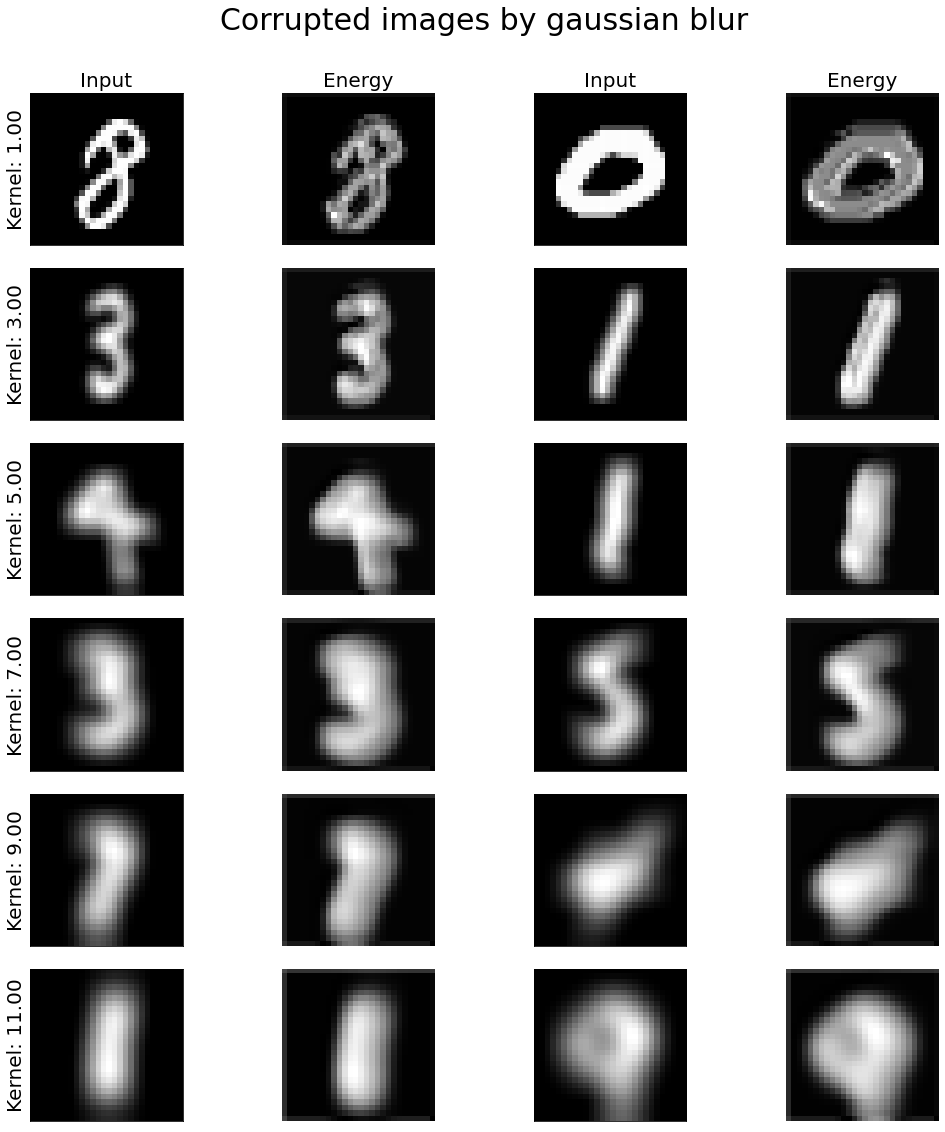

In [276]:
plot_energy(exp_gaussian_blur_all, eng_gaussian_blur_all, kernel_sizes, Title="Corrupted images by gaussian blur", y_label="Kernel", is_regular=0)

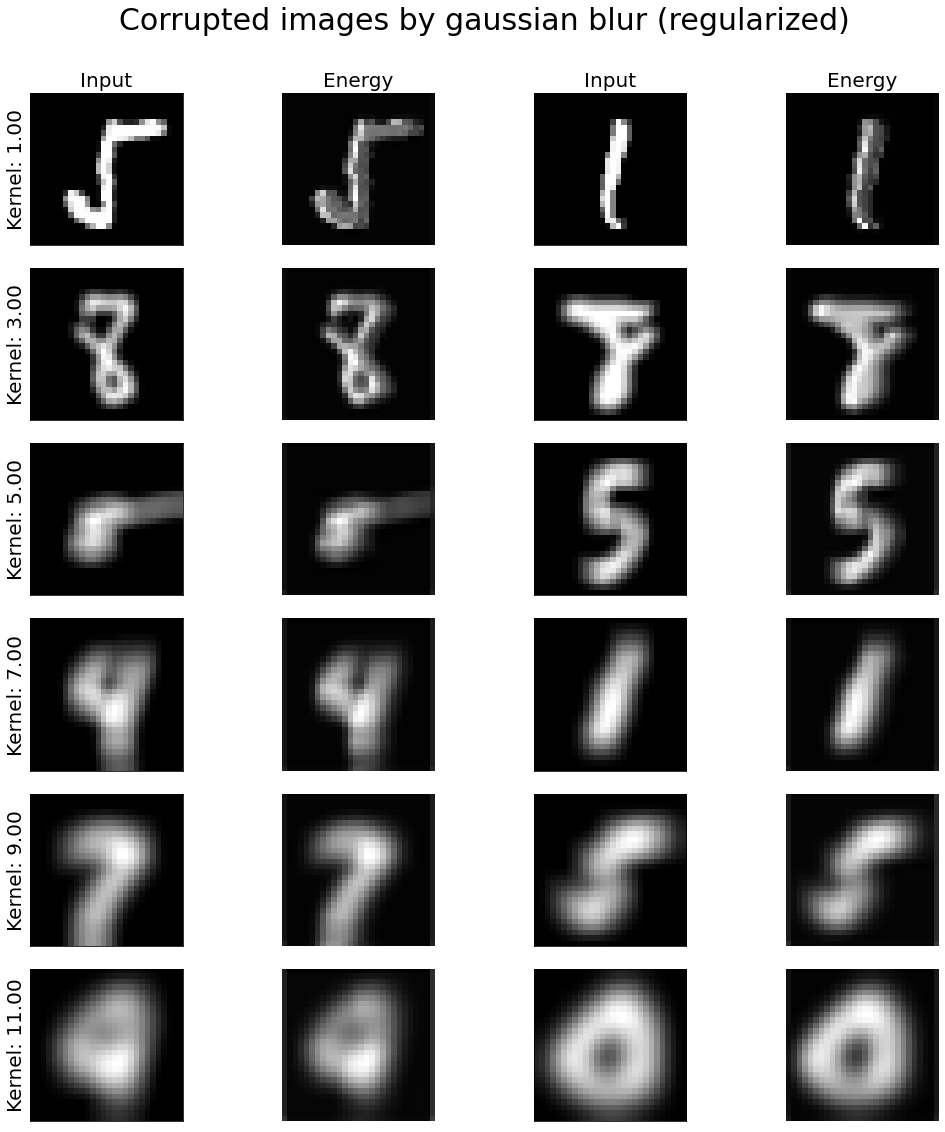

In [277]:
plot_energy(exp_gaussian_blur_all, eng_gaussian_blur_all, kernel_sizes, Title="Corrupted images by gaussian blur (regularized)", y_label="Kernel", is_regular=1)

In [216]:
def plot_accuracy(parameters, accuracies, Title, x_label, x_step):
  plt.figure(figsize=(5,5))
  plt.plot(parameters, accuracies[0], "*-", label='Energy based')
  plt.plot(parameters, accuracies[1], "r*-", label='H-DNN')
  plt.plot(parameters, accuracies[2], "g*-", label='Energy based (regularized)')
  plt.yticks(np.arange(0, 1.1, step=0.1))
  plt.xticks(np.arange(0, max(parameters)+x_step, step=x_step))
  plt.title(Title)
  plt.xlabel(x_label)
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

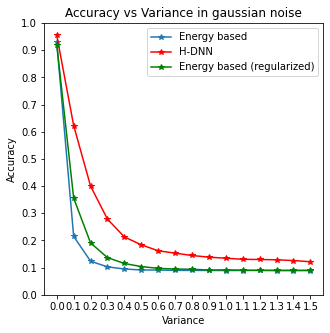

In [217]:
plot_accuracy(vars, acc_gaussian_all, Title="Accuracy vs Variance in gaussian noise", x_label="Variance", x_step=0.1)

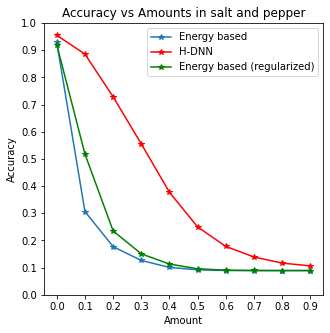

In [213]:
plot_accuracy(amounts, acc_salt_pepper_all, Title="Accuracy vs Amounts in salt and pepper", x_label="Amount",x_step=0.1)

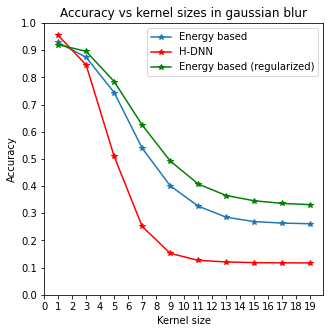

In [218]:
plot_accuracy(kernel_sizes, acc_gaussian_blur_all, Title="Accuracy vs kernel sizes in gaussian blur", x_label="Kernel size",x_step=1)

## Adversarial Attack

In [204]:
def test_fgsm(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = FGSM(model, eps=epsilon)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count != 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [206]:
def test_pgd(model, device, test_loader, out, epsilon=0.05, count=0):
    model.eval()
    correct = 0
    test_loss = 0
    atk = PGD(model, eps=epsilon, alpha=0.1, steps=7)
    for data, target in test_loader:
        data = data*0.3081 + 0.1307
        im_data = atk(data, target)
        im_data = (im_data-0.1307) / 0.3081
        if count != 2:
            H = model.getH()
        else:
            H = np.zeros(10)
        output = model(im_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Epsilon:{:.3f} Average loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            epsilon, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset), im_data[0:9], H[0:9]

In [229]:
epsilons_fgsm = np.linspace(0,0.5,11)

In [205]:
epsilons_fgsm = np.linspace(0,0.5,11)
acc_fgsm_all = []
exp_fgsm_all = []
eng_fgsm_all = []
count = 0
for model in models:
  print(model)
  count += 1
  acc_fgsm=[]
  exp_fgsm=[]
  eng_fgsm=[]
  for epsilon in epsilons_fgsm:
    test_acc, examples, energy = test_fgsm(model, device, test_loader, out, epsilon, count)
    acc_fgsm.append(test_acc)
    exp_fgsm.append(examples)
    eng_fgsm.append(energy)
  acc_fgsm_all.append(acc_fgsm)
  exp_fgsm_all.append(exp_fgsm)
  eng_fgsm_all.append(eng_fgsm)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=784, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.2481, Accuracy:  9286/10000 (92.86%)
Epsilon:0.050 Average loss: 0.7350, Accuracy:  7605/10000 (76.05%)
Epsilon:0.100 Average loss: 4.4697, Accuracy:  1387/10000 (13.87%)
Epsilon:0.150 Average loss: 11.2683, Accuracy:    44/10000 (0.44%)
Epsilon:0.200 Average loss: 17.6950, Accuracy:     0/10000 (0.00%)
Epsilon:0.250 Average loss: 23.1035, Accuracy:     0/10000 (0.00%)
Epsilon:0.300 Average loss: 27.6180, Accuracy:     0/10000 (0.00%)
Epsilon:0.350 Average loss: 31.4341, Accuracy:     0/10000 (0.00%)
Epsilon:0.400 Average loss: 34.7228, Accuracy:     0/10000 (0.00%)
Epsilon:0.450 Average loss: 37.6216, Accuracy:     0/10000 (0.00%)
Epsilon:0.500 Average loss: 40.2400, Accuracy:     0/10000 (0.00%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1)

In [235]:
epsilons_pgd = np.linspace(0,0.25,6)

In [207]:
epsilons_pgd = np.linspace(0,0.25,6)
acc_pgd_all = []
exp_pgd_all = []
eng_pgd_all = []
count = 0
for model in models:
  print(model)
  count += 1
  acc_pgd=[]
  exp_pgd=[]
  eng_pgd=[]
  for epsilon in epsilons_pgd:
    test_acc, examples, energy = test_pgd(model, device, test_loader, out, epsilon, count)
    acc_pgd.append(test_acc)
    exp_pgd.append(examples)
    eng_pgd.append(energy)
  acc_pgd_all.append(acc_pgd)
  exp_pgd_all.append(exp_pgd)
  eng_pgd_all.append(eng_pgd)

Net_Energy(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=784, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.2481, Accuracy:  9286/10000 (92.86%)
Epsilon:0.050 Average loss: 0.7239, Accuracy:  7650/10000 (76.50%)
Epsilon:0.100 Average loss: 4.4201, Accuracy:  1455/10000 (14.55%)
Epsilon:0.150 Average loss: 11.4815, Accuracy:    37/10000 (0.37%)
Epsilon:0.200 Average loss: 18.5287, Accuracy:     0/10000 (0.00%)
Epsilon:0.250 Average loss: 24.8401, Accuracy:     0/10000 (0.00%)
Net_HDNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hamiltonian): H1(
    (act): Tanh()
  )
  (fc_end): Linear(in_features=6272, out_features=10, bias=True)
)
Epsilon:0.000 Average loss: 0.1538, Accuracy:  9547/10000 (95.47%)
Epsilon:0.050 Average loss: 0.7475, Accuracy:  7505/10000 (75.05%)
Epsilon:0.100 Average loss: 3.3124, Accuracy:  3208/10000 (32.08%)
Epsilo

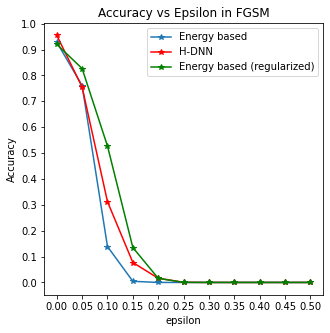

In [222]:
plot_accuracy(epsilons_fgsm, acc_fgsm_all, Title="Accuracy vs Epsilon in FGSM", x_label="epsilon",x_step=0.05)

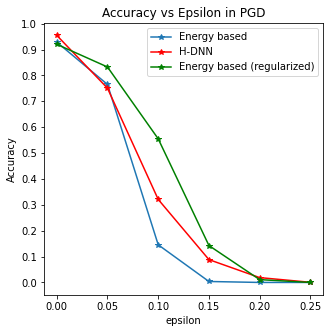

In [221]:
plot_accuracy(np.linspace(0,0.25,6), acc_pgd_all, Title="Accuracy vs Epsilon in PGD", x_label="epsilon",x_step=0.05)

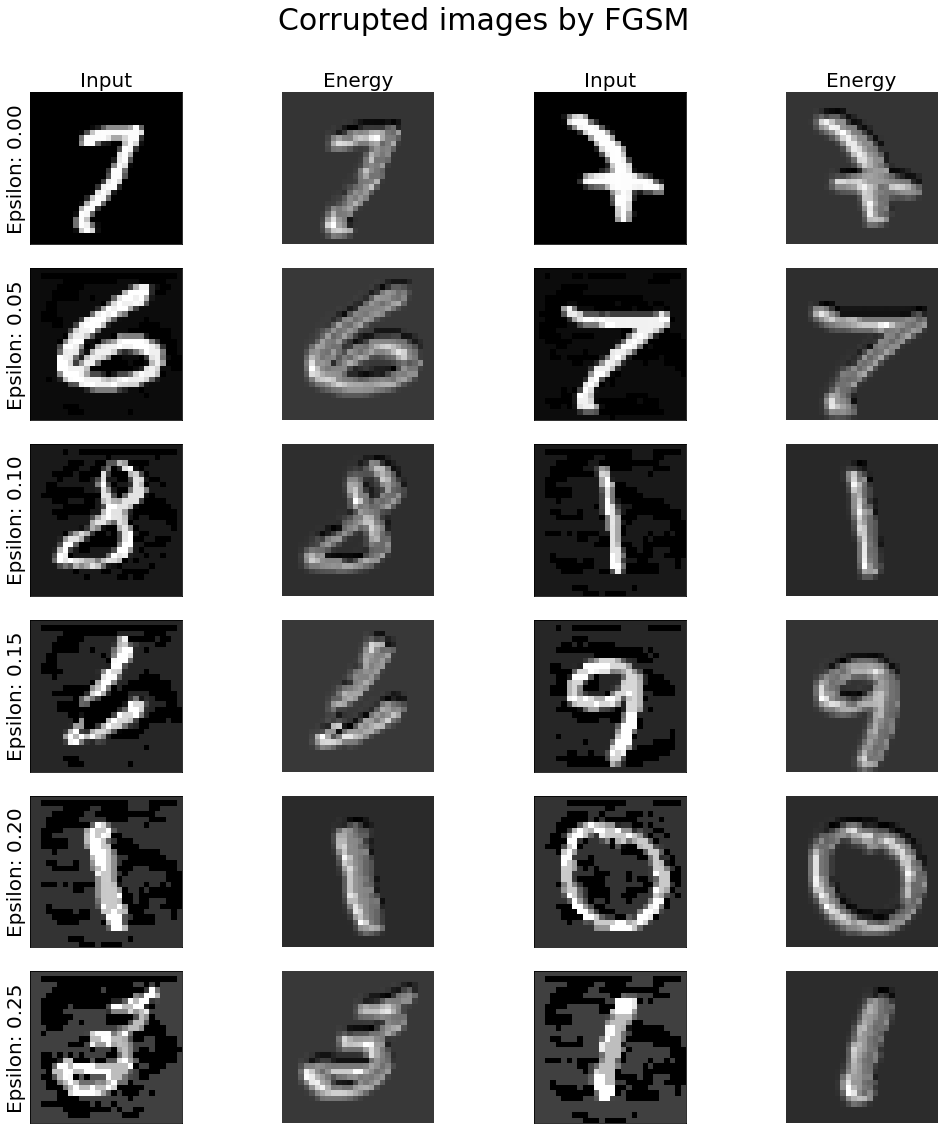

In [278]:
plot_energy(exp_fgsm_all, eng_fgsm_all, epsilons_fgsm, Title="Corrupted images by FGSM", y_label="Epsilon", is_regular=0)

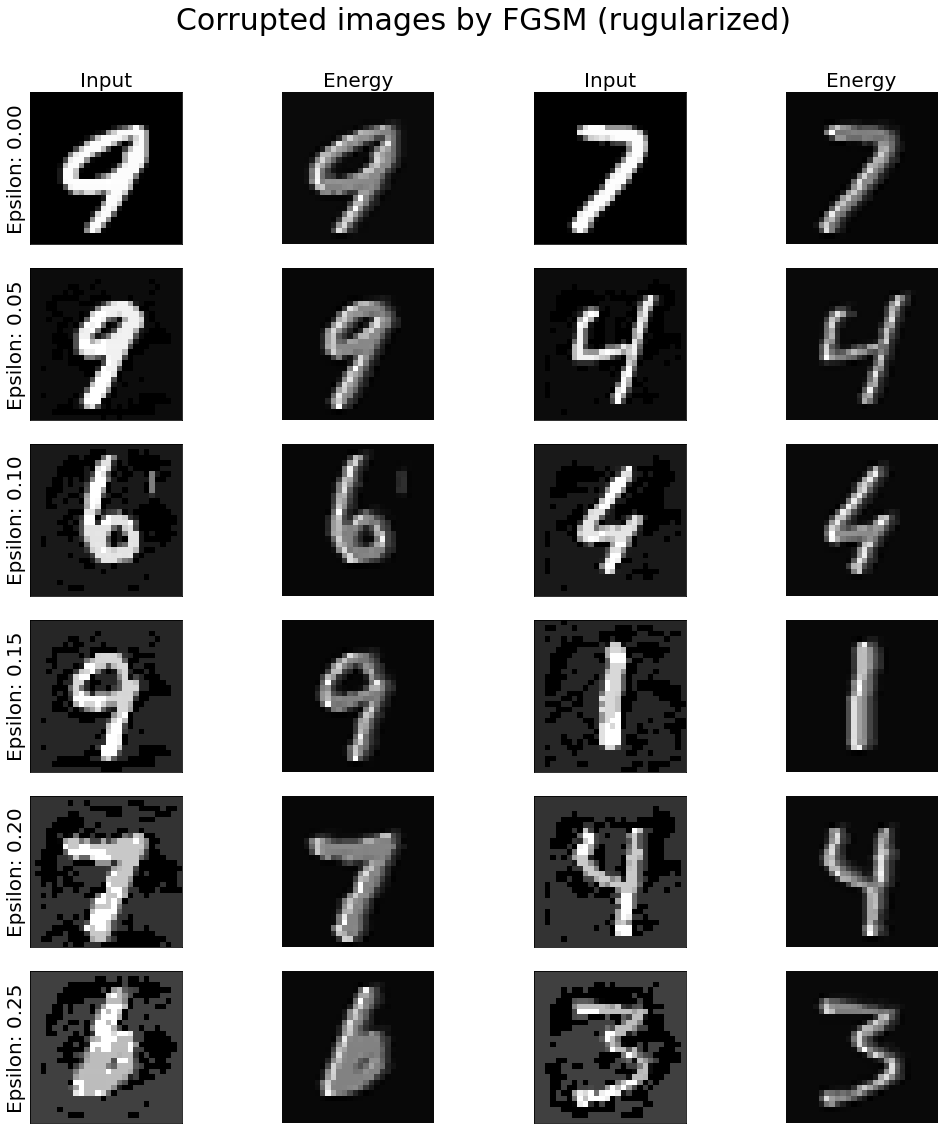

In [279]:
plot_energy(exp_fgsm_all, eng_fgsm_all, epsilons_fgsm, Title="Corrupted images by FGSM (rugularized)", y_label="Epsilon", is_regular=1)

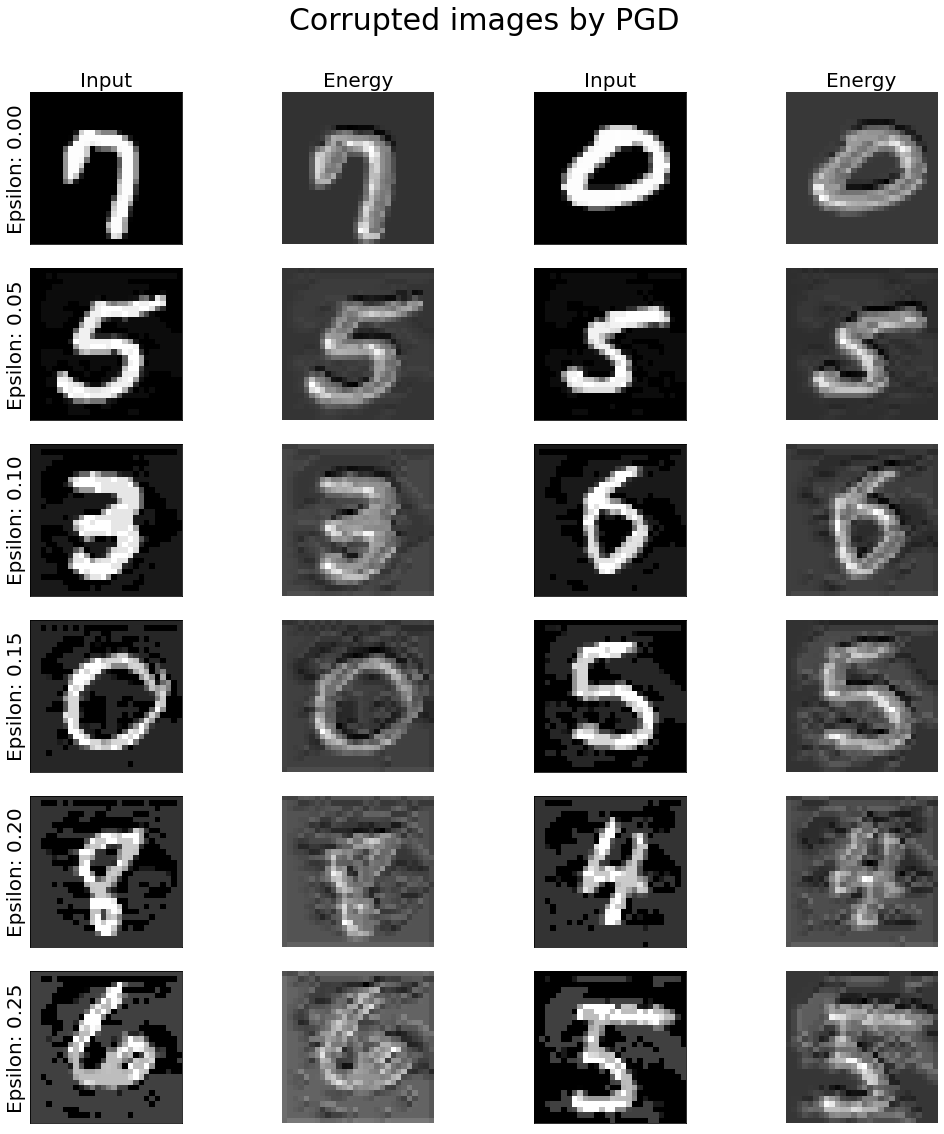

In [282]:
plot_energy(exp_pgd_all, eng_pgd_all, epsilons_pgd, Title="Corrupted images by PGD", y_label="Epsilon", is_regular=0)

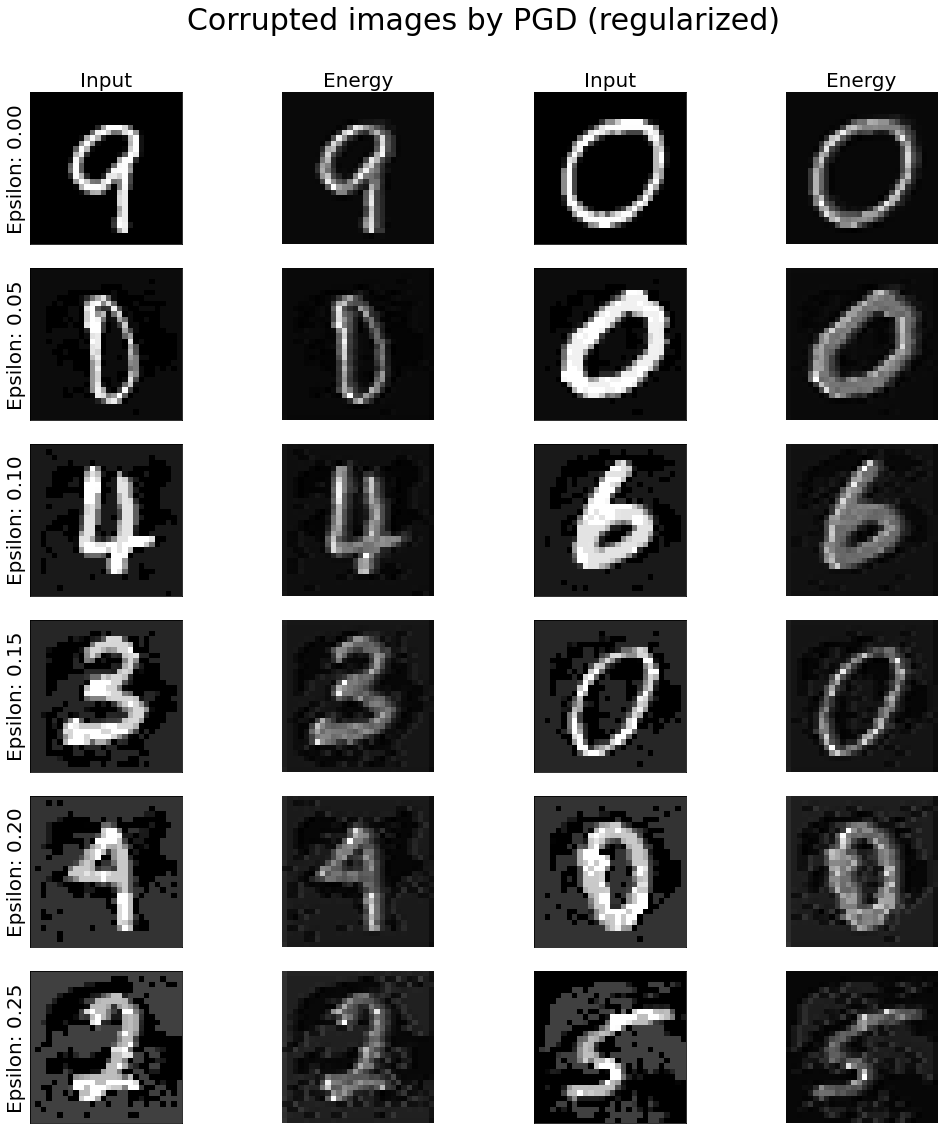

In [283]:
plot_energy(exp_pgd_all, eng_pgd_all, epsilons_pgd, Title="Corrupted images by PGD (regularized)", y_label="Epsilon", is_regular=1)